## Klinik Varyant Analizi (VCF Parsing & SNV/Indel Detection)
### Senaryo: Elimizde bir hastanın NGS cihazından çıkmış VCF verisi var. 

### Bizim görevimiz:

#### 1- Bu karmaşık dosyayı okumak.

#### 2- Mutasyonları SNV (Tek harf değişimi) ve INDEL (Ekleme/Silme) olarak sınıflandırmak.

#### 3- Kalitesi düşük olanları (LowQual) elemek.

#### 4- Klinik olarak tehlikeli olan (Pathogenic) mutasyonları tespit etmek.

🧬 VCF verisi yüklendi. Analiz başlatılıyor...

✅ Kalite Kontrolünden (QC) Geçen Varyantlar:


,#CHROM,POS,REF,ALT,Variant_Type,Depth (DP),Clinical_Risk
0,chr1,10020,A,G,SNV,120,Unknown
1,chr1,15040,C,CT,INDEL,85,Unknown
3,chr17,4124443,G,A,SNV,200,Pathogenic_BRCA1
4,chrX,30010,G,GC,INDEL,150,Benign
5,chrY,40020,A,C,SNV,110,Unknown


C:\Users\emree\AppData\Local\Temp\ipykernel_26536\4090311730.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Variant_Type', data=filtered_df, palette='Set2')
C:\Users\emree\AppData\Local\Temp\ipykernel_26536\4090311730.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Clinical_Risk', data=filtered_df, palette='Reds_r')


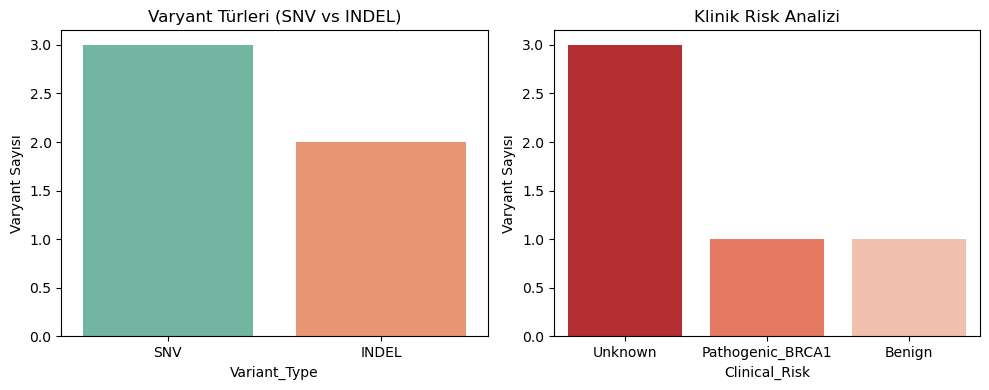


🚨 DİKKAT: Hastada Patojenik Varyant Tespit Edildi!
Kromozom: chr17, Pozisyon: 4124443
Detay: Pathogenic_BRCA1


In [1]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. VERİ SİMÜLASYONU: Mini VCF Dosyası ---
# Gerçek hayatta bu data hastanenin sunucusundan gelir.
vcf_content = """##fileformat=VCFv4.2
##source=Illumina_Pipeline
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">
##INFO=<ID=CLIN,Number=1,Type=String,Description="Clinical Significance">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO
chr1	10020	.	A	G	50	PASS	DP=120;TYPE=SNV
chr1	15040	rs123	C	CT	45	PASS	DP=85;TYPE=INDEL
chr2	20050	.	T	A	10	LowQual	DP=15;TYPE=SNV
chr17	4124443	rs386833395	G	A	99	PASS	DP=200;TYPE=SNV;CLIN=Pathogenic_BRCA1
chrX	30010	.	G	GC	88	PASS	DP=150;TYPE=INDEL;CLIN=Benign
chrY	40020	.	A	C	90	PASS	DP=110;TYPE=SNV
"""

print("🧬 VCF verisi yüklendi. Analiz başlatılıyor...")

# --- 2. VCF AYRIŞTIRMA (PARSING) FONKSİYONU ---
def parse_vcf(vcf_text):
    # '##' ile başlayan meta-bilgi satırlarını atla
    lines = [l for l in vcf_text.split('\n') if not l.startswith('##') and l.strip() != '']
    
    # Kalan veriyi Pandas DataFrame'e çevir
    df = pd.read_csv(io.StringIO('\n'.join(lines)), sep='\t')
    return df

vcf_df = parse_vcf(vcf_content)

# --- 3. BİYOİNFORMATİK FİLTRELEME & ANALİZ ---
# Sadece 'PASS' (Kaliteden geçen) varyantları al
filtered_df = vcf_df[vcf_df['FILTER'] == 'PASS'].copy()

# INFO sütunundan verileri çıkaralım (Feature Engineering)
filtered_df['Depth (DP)'] = filtered_df['INFO'].str.extract(r'DP=(\d+)').astype(int)
filtered_df['Variant_Type'] = filtered_df['INFO'].str.extract(r'TYPE=([A-Z]+)')
filtered_df['Clinical_Risk'] = filtered_df['INFO'].str.extract(r'CLIN=([A-Za-z0-9_]+)')
filtered_df['Clinical_Risk'] = filtered_df['Clinical_Risk'].fillna('Unknown')

print("\n✅ Kalite Kontrolünden (QC) Geçen Varyantlar:")
display(filtered_df[['#CHROM', 'POS', 'REF', 'ALT', 'Variant_Type', 'Depth (DP)', 'Clinical_Risk']])

# --- 4. KLİNİK RAPORLAMA (GÖRSELLEŞTİRME) ---
plt.figure(figsize=(10, 4))

# Alt Grafik 1: SNV vs INDEL Dağılımı
plt.subplot(1, 2, 1)
sns.countplot(x='Variant_Type', data=filtered_df, palette='Set2')
plt.title('Varyant Türleri (SNV vs INDEL)')
plt.ylabel('Varyant Sayısı')

# Alt Grafik 2: Klinik Risk Durumu
plt.subplot(1, 2, 2)
sns.countplot(x='Clinical_Risk', data=filtered_df, palette='Reds_r')
plt.title('Klinik Risk Analizi')
plt.ylabel('Varyant Sayısı')

plt.tight_layout()
plt.show()

# Patojenik (Tehlikeli) Varyant Uyarısı
pathogenic = filtered_df[filtered_df['Clinical_Risk'].str.contains('Pathogenic')]
if not pathogenic.empty:
    print("\n🚨 DİKKAT: Hastada Patojenik Varyant Tespit Edildi!")
    print(f"Kromozom: {pathogenic['#CHROM'].values[0]}, Pozisyon: {pathogenic['POS'].values[0]}")
    print(f"Detay: {pathogenic['Clinical_Risk'].values[0]}")




### Parsing: String işleme yöntemleriyle VCF dosyasının o karmaşık yapısını okunabilir bir tabloya (DataFrame) dönüştürdü.

### QC (Quality Control): FILTER == 'PASS' diyerek, cihazın kalitesiz okuduğu "LowQual" mutasyonları eledi. Yanlış pozitiflerin (False Positive) önüne geçildi.

### Klinik Yorumlama: Dünyaca ünlü kanser geni olan BRCA1 mutasyonunu (Meme kanseri riski) yakaladı ve sisteme kırmızı alarm verdirdi.